# Florida AgriPV Study with raytrace

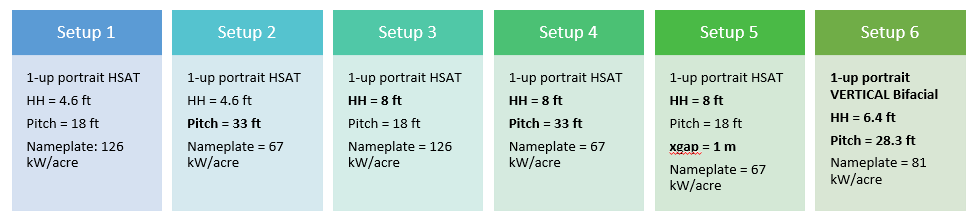

In [1]:
import os
from pathlib import Path
import bifacial_radiance as br
import numpy as np
import datetime
import pickle
import pandas as pd
import numpy as np

# Making folders for saving the simulations
basefolder = os.path.join(os.getcwd(), 'TEMP')

In [2]:
br.__version__

'0.4.2+143.gd6cf83b.dirty'

In [3]:
ft2m = 0.3048  # Conversion factor

In [4]:
# Setups

In [5]:
# Now per testbed...
resolutionGround = 0.1  # use 1 for faster test runs
xp = 10

In [6]:
lat = 30.480671646128137
lon = -83.92997540675283

#tilt = 25
sazm = 90 #

albedo = 0.2 # 'grass'

# Field size. Just going for 'steady state'
nMods = 20
nRows = 7

startdates = [pd.to_datetime('2021-01-01 6:0:0'),
              pd.to_datetime('2021-02-01 6:0:0'),
              pd.to_datetime('2021-03-01 6:0:0'),
              pd.to_datetime('2021-04-01 6:0:0'),
                pd.to_datetime('2021-05-01 6:0:0'), 
                pd.to_datetime('2021-06-01 6:0:0'),
                pd.to_datetime('2021-07-01 6:0:0'),
                pd.to_datetime('2021-08-01 6:0:0'),
                pd.to_datetime('2021-09-01 6:0:0'),
                pd.to_datetime('2021-10-01 6:0:0'),
                pd.to_datetime('2021-11-01 6:0:0'),
                pd.to_datetime('2021-12-01 6:0:0'),
                pd.to_datetime('2021-01-01 6:0:0'),
                pd.to_datetime('2021-05-01 6:0:0')]
enddates = [pd.to_datetime('2021-01-31 20:0:0'),
            pd.to_datetime('2021-02-28 20:0:0'),
            pd.to_datetime('2021-03-31 20:0:0'),
            pd.to_datetime('2021-04-30 20:0:0'),
            pd.to_datetime('2021-05-31 20:0:0'),    # May
            pd.to_datetime('2021-06-30 20:0:0'),   # June
            pd.to_datetime('2021-07-31 20:0:0'),   
            pd.to_datetime('2021-08-31 20:0:0'),
            pd.to_datetime('2021-09-30 20:0:0'), 
            pd.to_datetime('2021-10-31 20:0:0'), 
            pd.to_datetime('2021-11-30 20:0:0'), 
            pd.to_datetime('2021-12-31 20:0:0'), 
            pd.to_datetime('2021-12-31 20:0:0'),
           pd.to_datetime('2021-09-30 20:0:0')]
            

## Setups 1-5

In [8]:
for setup in range(1,7):
    for jj in range(0, len(startdates)): # 1):
        startdate = startdates[jj]
        enddate = enddates[jj]
        mymonthstart = startdate.month
        mymonthend = enddate.month

        simpath = f'Setup_{setup}_from_{mymonthstart}TO{mymonthend}'
        testfolder = os.path.join(basefolder, simpath)

        results_path = os.path.join(testfolder, 'results.pkl')
        #Check if simulation has already completed
        if os.path.isfile(results_path):
            print("***** SIM Done for ", simpath)
        else:
            print("STARTING ", setup, " from ", mymonthstart, " to ", mymonthend)

            if not os.path.exists(testfolder):
                os.makedirs(testfolder)


            if setup == 1:
                hub_height = 4.6*ft2m # 
                pitch = 18*ft2m
                xgap = 0.01 # m. Default 
                bedsWanted = 3
                modulename = 'basicModule'
                sazm = 180 # Tracker N-S axis orientation
                fixed_tilt_angle = None

            if setup == 2:
                hub_height = 4.6*ft2m # 
                pitch = 33*ft2m
                xgap = 0.01 # m. Default 
                bedsWanted = 6
                modulename = 'basicModule'
                sazm = 180 # Tracker N-S axis orientation
                fixed_tilt_angle = None

            if setup == 3:
                hub_height = 8*ft2m # 
                pitch = 18*ft2m
                xgap = 0.01 # m. Default 
                bedsWanted = 3
                modulename = 'basicModule'
                sazm = 180 # Tracker N-S axis orientation
                fixed_tilt_angle = None

            if setup == 4:
                hub_height = 8*ft2m # 
                pitch = 33*ft2m
                xgap = 0.01 # m. Default 
                bedsWanted = 6
                modulename = 'basicModule'
                sazm = 180 # Tracker N-S axis orientation
                fixed_tilt_angle = None

            if setup == 5:
                hub_height = 8*ft2m # 
                pitch = 18*ft2m
                xgap = 1.0 # m
                bedsWanted = 3
                modulename = 'spacedModule'
                sazm = 180 # Tracker N-S axis orientation
                fixed_tilt_angle = None

            if setup == 6:
                hub_height = 6.4*ft2m # 
                pitch = 28.3*ft2m
                xgap = 0.01 # m
                bedsWanted = 6
                xp = 2
                modulename = 'basicModule'
                sazm = 90 # VERTICAL facing East-West
                fixed_tilt_angle = 90


            radObj = br.RadianceObj('Setup',testfolder)

            radObj.setGround(albedo) 

            epwfile = radObj.getEPW(lat, lon) 
            metData = radObj.readWeatherFile(epwfile, starttime=startdate, endtime=enddate, coerce_year=2021)
            
            # -- establish tracking angles
            trackerParams = {'limit_angle':50,
                             'angledelta':5,
                             'backtrack':True,
                             'gcr':2/pitch,
                             'cumulativesky':True,
                             'azimuth': sazm,
                             'fixed_tilt_angle': fixed_tilt_angle,
                             }

            trackerdict = radObj.set1axis(**trackerParams)

            # -- generate sky   
            trackerdict = radObj.genCumSky1axis()

            sceneDict = {'pitch':pitch, 
                         'hub_height': hub_height,
                         'nMods': 19,
                         'nRows': 7,
                         'tilt': fixed_tilt_angle,  # CHECK IF THIS WORKS! 
                         'sazm': sazm}

            modWanted = 10
            rowWanted = 4


            testbedDmean = np.NaN
            testbedEmean = np.NaN 
            testbedFmean = np.NaN
            testbedD_normGHI = np.NaN 
            testbedE_normGHI = np.NaN 
            testbedF_normGHI = np.NaN


            basicModule = radObj.makeModule(name='basicModule', x=1, y=2)
            spacedModule = radObj.makeModule(name='spacedModule', x=1, y=2, xgap = 1)
            trackerdict = radObj.makeScene1axis(module=modulename,sceneDict=sceneDict) 

            trackerdict = radObj.makeOct1axis()

            # -- run analysis
            # Analysis for Module
            trackerdict = radObj.analysis1axis(trackerdict, customname = 'Module',
                                               sensorsy=9, modWanted=modWanted,
                                               rowWanted=rowWanted)
            trackerdict = radObj.calculateResults(agriPV=False)
            ResultPVWm2Back = radObj.CompiledResults.iloc[0]['Wm2Back']
            ResultPVWm2Front = radObj.CompiledResults.iloc[0]['Gfront_mean']

            # Modify modscanfront for Ground
            numsensors = int((pitch/resolutionGround)+1)
            modscanback = {'xstart': 0, 
                            'zstart': 0.05,
                            'xinc': resolutionGround,
                            'zinc': 0,
                            'Ny':numsensors,
                            'orient':'0 0 -1'}

            # Analysis for GROUND
            trackerdict = radObj.analysis1axis(trackerdict, customname = 'Ground',
                                               modWanted=modWanted, rowWanted=rowWanted,
                                                modscanback=modscanback, sensorsy=1)


            filesall = os.listdir('results')
            filestoclean = [e for e in filesall if e.endswith('_Front.csv')]
            for cc in range(0, len(filestoclean)):
                filetoclean = filestoclean[cc]
                os.remove(os.path.join('results', filetoclean))
            trackerdict = radObj.calculateResults(agriPV=True)
            ResultPVGround = radObj.CompiledResults.iloc[0]['Wm2Back']
            ghi_sum = metData.ghi.sum()
            ghi_sum

            # GROUND TESTBEDS COMPILATION
            # Tracker Projection of half the module into the ground, 
            # for 1-up module in portrait orientation


            df_temp = ResultPVGround
            # Under panel irradiance calculation
            edgemean = np.mean(df_temp[:xp] + df_temp[-xp:])
            edge_normGHI = edgemean / ghi_sum

            # All testbeds irradiance average
            insidemean = np.mean(df_temp[xp:-xp])
            inside_normGHI = insidemean / ghi_sum

            # Length of each testbed between rows
            dist1 = int(np.floor(len(df_temp[xp:-xp])/bedsWanted))

            Astart = xp + dist1*0
            Bstart = xp + dist1*1
            Cstart = xp + dist1*2

            if bedsWanted == 3:
                Dstart = -xp # in this case it is Cend
            if bedsWanted > 3:
                Dstart = xp + dist1*3
                Estart = xp + dist1*4
                Fstart = xp + dist1*5
                Gstart = -xp  # in this case it is Fend
            if bedsWanted > 6:
                Gstart = xp + dist1*6
                Hstart = xp + dist1*7
                Istart = xp + dist1*8
                Iend = -xp # this is I end

            testbedA = df_temp[Astart:Bstart]
            testbedAmean = np.mean(testbedA)
            testbedA_normGHI = testbedAmean / ghi_sum

            testbedB = df_temp[Bstart:Cstart]
            testbedBmean = np.mean(testbedB)
            testbedB_normGHI = testbedBmean / ghi_sum

            testbedC = df_temp[Cstart:Dstart]
            testbedCmean = np.mean(testbedC)
            testbedC_normGHI = testbedCmean / ghi_sum

            # Will run for bedswanted 6 and 9
            if bedsWanted > 3:
                testbedD = df_temp[Dstart:Estart]
                testbedDmean = np.mean(testbedD)
                testbedD_normGHI = testbedDmean / ghi_sum

                testbedE = df_temp[Estart:Fstart]
                testbedEmean = np.mean(testbedE)
                testbedE_normGHI = testbedEmean / ghi_sum

                testbedF = df_temp[Fstart:Gstart]
                testbedFmean = np.mean(testbedF)
                testbedF_normGHI = testbedFmean / ghi_sum

            # Compiling for return
            results = [setup, metData.latitude, metData.longitude, 
            mymonthstart, mymonthend,
            ghi_sum,
            ResultPVWm2Front, ResultPVWm2Back, ResultPVGround,
            edgemean, insidemean,
            testbedAmean, testbedBmean, testbedCmean,
            testbedDmean, testbedEmean, testbedFmean,
            edge_normGHI, inside_normGHI,
            testbedA_normGHI, testbedB_normGHI, testbedC_normGHI,
            testbedD_normGHI, testbedE_normGHI, testbedF_normGHI]
            # save to folder

            with open('results.pkl', "wb") as fp:   #Pickling
                pickle.dump(results, fp)

***** SIM Done for  Setup_1_from_1TO1
***** SIM Done for  Setup_1_from_2TO2
***** SIM Done for  Setup_1_from_3TO3
***** SIM Done for  Setup_1_from_4TO4
***** SIM Done for  Setup_1_from_5TO5
***** SIM Done for  Setup_1_from_6TO6
***** SIM Done for  Setup_1_from_7TO7
***** SIM Done for  Setup_1_from_8TO8
***** SIM Done for  Setup_1_from_9TO9
***** SIM Done for  Setup_1_from_10TO10
***** SIM Done for  Setup_1_from_11TO11
***** SIM Done for  Setup_1_from_12TO12
***** SIM Done for  Setup_1_from_1TO12
***** SIM Done for  Setup_1_from_5TO9
***** SIM Done for  Setup_2_from_1TO1
***** SIM Done for  Setup_2_from_2TO2
***** SIM Done for  Setup_2_from_3TO3
***** SIM Done for  Setup_2_from_4TO4
***** SIM Done for  Setup_2_from_5TO5
***** SIM Done for  Setup_2_from_6TO6
***** SIM Done for  Setup_2_from_7TO7
***** SIM Done for  Setup_2_from_8TO8
***** SIM Done for  Setup_2_from_9TO9
***** SIM Done for  Setup_2_from_10TO10
***** SIM Done for  Setup_2_from_11TO11
***** SIM Done for  Setup_2_from_12TO12

In [ ]:
# SETUP 6 - FIXED TILT

'''
for mmonth in range(0, len(startdts)):
    startdt = startdts[mmonth]
    enddt = enddts[mmonth]
    metdata = radObj.readWeatherFile(epwfile, starttime=startdt, endtime=enddt, coerce_year=2021) # read in the EPW weather data from above
    radObj.genCumSky(savefile=str(mmonth))
    #radObj.gendaylit(4020)  # Use this to simulate only one hour at a time. 

    sceneDict = {'tilt':tilt, 'pitch':pitch, 'hub_height':hub_height, 
                 'azimuth':sazm, 'nMods':nMods, 'nRows':nRows}  
    scene = radObj.makeScene(module=spacedmodule, sceneDict=sceneDict) 
    octfile = radObj.makeOct(radObj.getfilelist())  

    analysis = br.AnalysisObj(octfile, radObj.name)
    spacingbetweensamples = 0.05 # m
    sensorsy = int(np.floor(pitch/spacingbetweensamples)+1)
    sensorsx = 1

    # Module first
    frontscan, backscan = analysis.moduleAnalysis(scene, sensorsx = 1, sensorsy=10)
    analysis.analysis(octfile, 'MODULE_Month_'+str(mmonth+4)+'_setup_'+(str(setup)), frontscan, backscan)  # compare the back vs front irradiance  

    groundscan, backscan = analysis.moduleAnalysis(scene, sensorsx = 1, sensorsy=[sensorsy, 1])
    groundscan['zstart'] = 0.05  # setting it 5 cm from the ground.
    groundscan['zinc'] = 0   # no tilt necessary. 
    groundscan['yinc'] = spacingbetweensamples
    groundscan['ystart'] = 0
    groundscan['xinc'] = 0
    groundscan['xstart'] = 0

    analysis.analysis(octfile, 'GROUND_Month_'+str(mmonth+4)+'_setup_'+(str(setup)), groundscan, backscan)  # compare the back vs front irradiance  

filesall = os.listdir('results')

# Cleanup of Ground 'back' files
filestoclean = [e for e in filesall if e.endswith('_Back.csv')]
for cc in range(0, len(filestoclean)):
    filetoclean = filestoclean[cc]
    os.remove(os.path.join('results', filetoclean))
    
'''